### Task 10: Add Constant Product Trading interest rate as continuous rebase
* https://cryptorating.eu/whitepapers/Aave/aave-v2-whitepaper.pdf

In [1]:
import os
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
cwd =  os.getcwd().replace("notebooks/test","")
os.chdir(cwd)

from python.dev.event.state.series import StateSeries
from python.dev.event.state import State
from python.dev.event import Deposit
from python.dev.event import Withdraw
from python.dev.token.trade import Convert
from python.dev.cpt import Liquidity
from python.dev.cpt import PriceCurve
from python.dev.cpt import ConstantProductTrade
from python.dev.plot import PlotPriceCurve
from python.dev.token import RebaseToken
from python.dev.math.model import TimeDeltaModel
from python.dev.math.model import TokenDeltaModel
from python.dev.math.model import EventSelectionModel

In [2]:
time0 = time.time()

In [3]:
APY = 0.1
state = State(Deposit(0,0,0))
state.init_first_state(time0)
state_series = StateSeries()

for k in range(320):
    delta = TokenDeltaModel(1,10).apply()  
    select = EventSelectionModel().bi_select(0.7)
    t_delta = TimeDeltaModel().apply()
      
    if(select == EventSelectionModel().FIRST): 
        event = Deposit(APY,delta,t_delta)
    else:
        event = Withdraw(APY,delta,t_delta)  

    state.update_event(event)
    state_series.add_state(state)
    

principle = state_series.get_principle() 
balance = state_series.get_balance() 
tSamp = state_series.get_tstamp()

In [4]:
for k in range(10):
    type_event = state_series.get_state(k).get_event().type_of()
    print('{}: {} @ {}'.format(k, type_event, tSamp[k]))

0: DEPOSIT @ 2022-04-21 13:37:25.251334
1: WITHDRAW @ 2022-04-22 08:39:25.251334
2: DEPOSIT @ 2022-04-23 09:20:41.251334
3: WITHDRAW @ 2022-04-24 00:55:37.251334
4: DEPOSIT @ 2022-04-24 12:57:43.251334
5: DEPOSIT @ 2022-04-25 15:30:58.251334
6: DEPOSIT @ 2022-04-26 02:24:39.251334
7: DEPOSIT @ 2022-04-27 00:10:46.251334
8: DEPOSIT @ 2022-04-27 09:59:50.251334
9: DEPOSIT @ 2022-04-28 15:58:07.251334


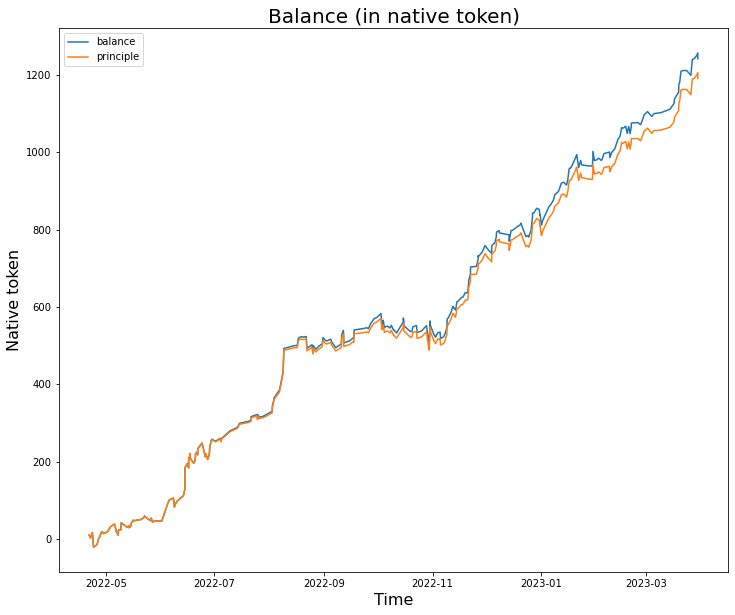

In [5]:
import matplotlib.pyplot as plt

fig, (balance_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(12, 10))

balance_ax.plot(tSamp, balance, label='balance') 
balance_ax.plot(tSamp, principle, label='principle') 

balance_ax.set_title("Balance (in native token)", fontsize=20)
balance_ax.set_ylabel("Native token", fontsize=16)
balance_ax.set_xlabel('Time', fontsize=16)
balance_ax.legend()


In [8]:
# Initialize Test Tokens

TYPE_DEPOSIT_TOKEN = 'DEPOSIT'
TYPE_DEBT_TOKEN = 'DEBT'

t_delta = TimeDeltaModel().apply()
depositT1 = TokenDeltaModel(2,2000).apply() 

T1 = RebaseToken(TYPE_DEPOSIT_TOKEN)
t1Address = T1.gen_address()
T1.init_token(time0, t1Address)
T1.add_event(Deposit(APY, depositT1, t_delta, t1Address))

t_delta = TimeDeltaModel().apply()
depositTDT = TokenDeltaModel(2,2000).apply() 

TDT = RebaseToken(TYPE_DEBT_TOKEN)
tdtAddress = TDT.gen_address()
TDT.init_token(time0, tdtAddress)
TDT.add_event(Deposit(APY, depositTDT, t_delta, tdtAddress))

x = T1.get_balance_deposits()
y = TDT.get_balance_deposits()

print('[Initial] T1: {:.2f} TDT: {:.2f}\n'.format(x,y))

[Initial] T1: 5718.38 TDT: 3545.35



In [11]:
# Initialize Liquidity Pool
liq = Liquidity(x,y)
L = liq.calc(); p = np.random.normal(5,0.1,1)[0]
cpt = ConstantProductTrade(L)
pCurve = PriceCurve(L)

[Trade 0] T1: 5320.07113 TDT: 5466.81817 L: 5080.22300
[Trade 0] T1_prin: 5718.37598 T1_balance: 5718.37598
[Trade 0] TDT_prin: 3545.34875 TDT_balance: 3545.34875

[Trade 50] T1: 5584.80474 TDT: 5375.33736 L: 5229.51083
[Trade 50] T1_prin: 6800.34516 T1_balance: 6918.57849
[Trade 50] TDT_prin: 2463.37956 TDT_balance: 2502.04478

[Trade 100] T1: 6321.55757 TDT: 4831.49097 L: 5420.37684
[Trade 100] T1_prin: 7567.61497 T1_balance: 7801.68948
[Trade 100] TDT_prin: 1696.10976 TDT_balance: 1780.40974

[Trade 150] T1: 5816.58886 TDT: 5515.46352 L: 5524.83245
[Trade 150] T1_prin: 7635.95570 T1_balance: 7975.02364
[Trade 150] TDT_prin: 1627.76903 TDT_balance: 1734.76884

[Trade 200] T1: 3125.37217 TDT: 8384.35219 L: 5734.85558
[Trade 200] T1_prin: 6258.20007 T1_balance: 6696.75540
[Trade 200] TDT_prin: 3005.52466 TDT_balance: 3155.68762



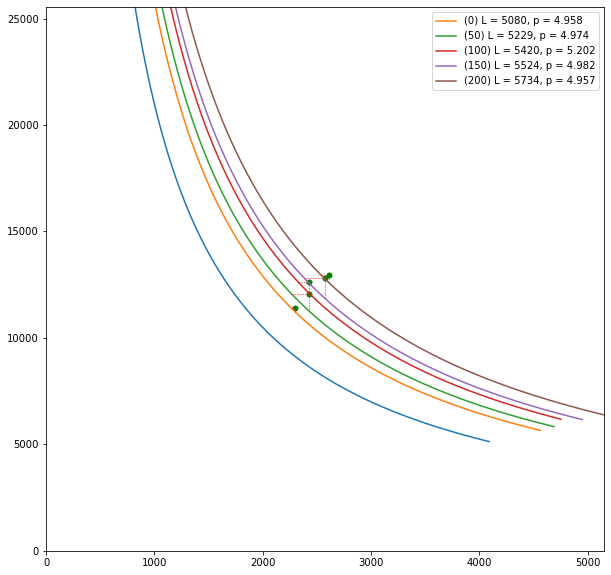

In [13]:
# Plot and execute N trades
percent = 0.05
N = 250

plotCurve = PlotPriceCurve(L, cpt, pCurve)
plotCurve.apply(p, None)

for k in range(N):
    # Generate random delta denomenated in Native token, 
    # rebalance respective accounts and convert to T1
    delta_x = TokenDeltaModel(1,100).apply() 
    t_delta = TimeDeltaModel().apply()

    select = EventSelectionModel().bi_select(0.5)
    if(select == EventSelectionModel().FIRST): 
        T1.add_event(Withdraw(APY, delta_x, t_delta, t1Address))
        TDT.add_event(Deposit(APY, delta_x, t_delta, tdtAddress))               
    else:            
        T1.add_event(Deposit(APY, delta_x, t_delta, t1Address))
        TDT.add_event(Withdraw(APY, delta_x, t_delta, tdtAddress))         
    
    TDT_yield = TDT.get_state_series(tdtAddress).get_state(k).get_yield()
    T1_yield = T1.get_state_series(t1Address).get_state(k).get_yield()
    
    liq.add_y(TDT_yield)
    liq.add_x(T1_yield) 
    
    L = liq.update(delta_x); p = np.random.normal(5,0.1,1)[0]
    if (k % int(N/(100*percent)) == 0):
        plotCurve.apply_next(p, L, '({}) L = {}, p = {:.3f}'.format(k, int(L),p))
        plotCurve.plot_trade(p, delta_x, 'r--')
        T1_prin = T1.get_state_series(t1Address).get_state(k).get_principle()
        T1_balance = T1.get_state_series(t1Address).get_state(k).get_balance()

        TDT_prin = TDT.get_state_series(tdtAddress).get_state(k).get_principle()
        TDT_balance = TDT.get_state_series(tdtAddress).get_state(k).get_balance()
            
        print('[Trade {}] T1: {:.5f} TDT: {:.5f} L: {:.5f}'.format(k, x,y,L))
        print('[Trade {}] T1_prin: {:.5f} T1_balance: {:.5f}'.format(k, T1_prin,T1_balance))
        print('[Trade {}] TDT_prin: {:.5f} TDT_balance: {:.5f}\n'.format(k, TDT_prin,TDT_balance))
      
    x = T1.get_balance_deposits()
    y = TDT.get_balance_deposits()



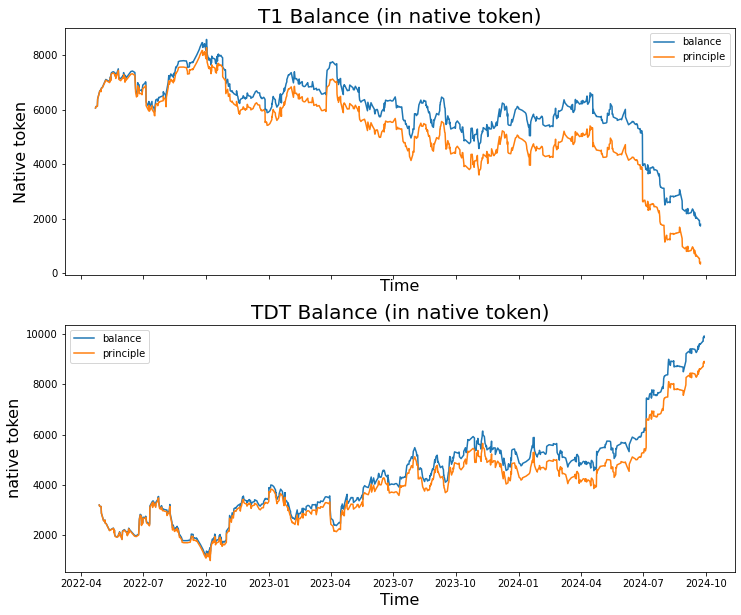

In [14]:
# Analyze Token balances

T1_states = T1.get_state_series(t1Address)
principle = T1_states.get_principle() 
balance = T1_states.get_balance() 
tSamp = T1_states.get_tstamp()  

fig, (T1_ax, TDT_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

T1_ax.plot(tSamp[1:], balance[1:], label='balance') 
T1_ax.plot(tSamp[1:], principle[1:], label='principle') 
T1_ax.set_title("T1 Balance (in native token)", fontsize=20)
T1_ax.set_ylabel("Native token", fontsize=16)
T1_ax.set_xlabel('Time', fontsize=16)
T1_ax.legend()

TDT_states = TDT.get_state_series(tdtAddress)
principle = TDT_states.get_principle() 
balance = TDT_states.get_balance() 
tSamp = TDT_states.get_tstamp() 

TDT_ax.plot(tSamp[1:], balance[1:], label='balance') 
TDT_ax.plot(tSamp[1:], principle[1:], label='principle') 
TDT_ax.set_title("TDT Balance (in native token)", fontsize=20)
TDT_ax.set_ylabel("native token", fontsize=16)
TDT_ax.set_xlabel('Time', fontsize=16)
TDT_ax.legend()